In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression, Lars, LassoLars
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, accuracy_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
import joblib
import seaborn as sns
from itertools import product

# another way of ignoring warnings
warnings.filterwarnings('ignore')

In [14]:
### Importing data
df = pd.read_csv("case1Data.csv")
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
df.head(10)

,y,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,...,x_91,x_92,x_93,x_94,x_95,C_01,C_02,C_03,C_04,C_05
0,375.823073,6.359019,-13.367120,-2.483750,-6.641891,11.733539,NaN,-17.085361,22.194764,16.827888,...,-10.200888,3.980048,-4.433274,-1.473723,NaN,74.0,72.0,72.0,73.0,73.0
1,266.811730,3.873664,-8.470389,-3.055012,NaN,11.420983,1.822330,-13.694100,22.738654,20.307503,...,-9.740207,NaN,-2.629314,4.816987,-12.240248,74.0,72.0,72.0,73.0,73.0
2,267.271759,5.275824,-12.070531,-1.366168,-4.819100,10.721527,-5.125992,-17.476865,NaN,15.963889,...,-14.501970,10.054005,NaN,NaN,-11.107921,73.0,72.0,75.0,74.0,74.0
3,219.951294,4.430110,-4.467975,-0.730736,-10.047104,11.498539,-2.870260,-14.033012,18.225190,10.409488,...,-11.086963,2.019726,-8.531959,3.520833,NaN,71.0,72.0,73.0,71.0,72.0
4,289.697954,3.116458,-8.518713,-6.796050,NaN,7.646285,-3.118309,-13.102567,22.801217,16.680208,...,-9.117422,6.627601,-2.805531,5.914351,-11.240573,72.0,72.0,72.0,74.0,75.0
5,265.753204,2.478883,-10.347278,-3.574333,-4.320143,NaN,-3.326662,-13.197508,23.424267,12.551075,...,-11.571283,7.487204,-5.098366,3.175914,-9.610356,71.0,72.0,74.0,71.0,75.0
6,133.594186,0.497803,-9.389992,-7.230404,-8.852222,12.308068,-5.288380,-9.998207,23.229430,13.491712,...,-15.720359,NaN,-6.235942,4.124001,-16.268568,74.0,72.0,75.0,71.0,75.0
7,252.251096,7.627311,-7.146660,0.244472,0.182987,NaN,-0.395215,-14.423119,NaN,NaN,...,-10.710254,7.884195,-2.402023,NaN,-4.631043,74.0,72.0,73.0,75.0,73.0
8,163.402815,4.981034,-8.719028,-5.484942,-5.919929,9.916674,-4.726807,-10.606375,24.903043,12.151393,...,-11.139651,7.096430,-2.865486,7.464922,-8.441735,NaN,NaN,NaN,NaN,NaN
9,282.511836,0.519655,-14.477831,-2.121282,NaN,12.080162,-6.393721,-11.599432,NaN,11.984299,...,-14.195198,2.409425,-3.523658,2.821658,-14.591262,75.0,72.0,72.0,74.0,71.0


In [15]:
Xtrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 1:]
ytrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 0]
Xtest = pd.read_csv("Xytest_regression.csv").iloc[:, 1:]
ytest = pd.read_csv("Xytest_regression.csv").iloc[:, 0]

Xall = pd.concat([Xtrain, Xtest], axis=0).reset_index(drop=True)
yall = pd.concat([ytrain, ytest], axis=0).reset_index(drop=True)

In [16]:
n, p = Xtrain.shape

In [17]:
ridge = Ridge(alpha=0.5)
ridge.fit(Xtrain, ytrain)
ridge_pred = ridge.predict(Xtest)

# 2. Train KNN Regressor with 1 neighbor
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(Xtrain, ytrain)
knn_pred = knn.predict(Xtest)

# 3. Weighted combination of predictions
final_pred = 0.85 * ridge_pred + 0.15 * knn_pred

# 4. Evaluate performance
rmse = root_mean_squared_error(ytest, final_pred)
print(f"Final Model RMSE: {rmse:.4f}")

Final Model RMSE: 51.8998


In [18]:
def center_dataframe(data):
    mu = data.mean()
    data = data - mu
    return data, mu

In [19]:
def handlingOfdata(Xtrain, Xtest, ytrain, ytest):
    # train set
    Xtrain_cont = Xtrain.iloc[:, :95]
    Xtrain_cat = Xtrain.iloc[:, 95:]

    # test set
    Xtest_cont = Xtest.iloc[:, :95]
    Xtest_cat = Xtest.iloc[:, 95:]

    #centering of the target values
    ytrain_centr, miu = center_dataframe(ytrain)
    ytest_centr = ytest-miu

    # --- Scaling Continuous Variables ---
    standard_scaler = StandardScaler()
    Xtrain_cont_scaled = standard_scaler.fit_transform(Xtrain_cont)
    Xtest_cont_scaled = standard_scaler.transform(Xtest_cont)

    # --- KNN Imputation for Continuous Variables ---
    knn_imput = KNNImputer(n_neighbors=5)
    X_train_cont_imputed = knn_imput.fit_transform(Xtrain_cont_scaled)
    X_test_cont_imputed = knn_imput.transform(Xtest_cont_scaled)

    # Convert to DataFrame 
    X_train_cont_imputed = pd.DataFrame(X_train_cont_imputed, columns=Xtrain_cont.columns, index=Xtrain_cont.index)
    X_test_cont_imputed = pd.DataFrame(X_test_cont_imputed, columns=Xtest_cont.columns, index=Xtest_cont.index)

    # --- Imputation for Categorical Variables ---
    simple_imput = SimpleImputer(strategy="most_frequent")
    Xtrain_cat_imputed = simple_imput.fit_transform(Xtrain_cat)
    Xtest_cat_imputed = simple_imput.transform(Xtest_cat)

    # Convert to DataFrame 
    Xtrain_cat_imputed = pd.DataFrame(Xtrain_cat_imputed, columns=Xtrain_cat.columns, index=Xtrain_cat.index)
    Xtest_cat_imputed = pd.DataFrame(Xtest_cat_imputed, columns=Xtest_cat.columns, index=Xtest_cat.index)
    

    # --- 1 HOT encoding ---
    Xtrain_cat_imputed1HOT = pd.get_dummies(Xtrain_cat_imputed, columns=Xtrain_cat_imputed.columns, drop_first=False).astype(int)
    Xtest_cat_imputed1HOT = pd.get_dummies(Xtest_cat_imputed, columns=Xtrain_cat_imputed.columns, drop_first=False).astype(int)
    # Ensure that both train and test have the same columns
    Xtest_cat_imputed1HOT = Xtest_cat_imputed1HOT.reindex(columns=Xtrain_cat_imputed1HOT.columns, fill_value=0)

    # --- Align the target variable with the feature DataFrames ---
    # --- for Regression models ---
    # --- Concatenate Continuous and Categorical Data ---
    Xtrain_final = pd.concat([X_train_cont_imputed, Xtrain_cat_imputed1HOT], axis=1)
    Xtest_final = pd.concat([X_test_cont_imputed, Xtest_cat_imputed1HOT], axis=1)

    return Xtrain_final, Xtest_final, ytrain_centr, ytest_centr


# All (2-lvl CV to find the best model)

In [20]:
alphas_ = [0, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 3, 4, 5, 7, 10]
neigbours = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]

In [21]:
# Cross-validation procedure (outer loop)
cv_outer = KFold(n_splits=5, shuffle=True, random_state=6)

# Define models and their parameter grids
models_dict = {
    'ridge': (Ridge(), {'alpha': alphas_}),
    'lasso': (Lasso(), {'alpha': alphas_}),
    'lars': (Lars(), {'n_nonzero_coefs': range(1, p+1)}),
    'elastic': (ElasticNet(), {'alpha': alphas_, 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]}),
    'pls' : (PLSRegression(), {'n_components' : range(1, p+1)}),
    'knn': (KNeighborsRegressor(), {'n_neighbors': neigbours}),
    'ols': (LinearRegression(), {})  # OLS model (no hyperparameters to tune)
}

# Lists to store the results
outer_results = []
model_rmse_dict = {model_name: [] for model_name in models_dict.keys()}
model_r2_dict = {model_name: [] for model_name in models_dict.keys()}
model_best_params_dict = {model_name: [] for model_name in models_dict.keys()}

# Loop over the outer cross-validation splits
for fold_num, (train_ix, test_ix) in enumerate(cv_outer.split(X), 1):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    cv_inner = KFold(n_splits=5, shuffle=True, random_state=6)

    best_rmse = float('inf')
    best_r2 = float('-inf')
    best_model_name = None
    best_params = None

    for model_name, (model, param_grid) in models_dict.items():
        if model_name != "ols":  # Skip GridSearch for OLS (no hyperparameters)
            search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=cv_inner, refit=True)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            best_params = search.best_params_
        else:
            best_model = model.fit(X_train, y_train)
            best_params = None  # No hyperparameters for OLS

        # Predict and evaluate
        yhat = best_model.predict(X_test)
        rmse = root_mean_squared_error(y_test, yhat)
        r2 = r2_score(y_test, yhat)

        model_rmse_dict[model_name].append(rmse)
        model_r2_dict[model_name].append(r2)
        model_best_params_dict[model_name].append(best_params)

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_model_name = model_name
            best_params = best_params if model_name != "ols" else None  # Ensure correct param tracking

    # Store the best model for each fold
    outer_results.append((fold_num, best_model_name, best_rmse, best_r2, best_params))
    print(f'Fold {fold_num}: Best Model: {best_model_name}, RMSE={best_rmse:.3f}, R²={best_r2:.3f}')
    print(f'Best Hyperparameters: {model_best_params_dict[best_model_name][fold_num-1]}')

# Summary statistics
print('\nOverall RMSE and R² for each model:')
for model_name in models_dict.keys():
    overall_rmse = np.mean(model_rmse_dict[model_name])
    overall_r2 = np.mean(model_r2_dict[model_name])
    print(f'{model_name}: Overall RMSE={overall_rmse:.3f}, Overall R²={overall_r2:.3f}')

Fold 1: Best Model: lars, RMSE=23.731, R²=0.895
Best Hyperparameters: {'n_nonzero_coefs': 21}
Fold 2: Best Model: lasso, RMSE=28.374, R²=0.839
Best Hyperparameters: {'alpha': 1}
Fold 3: Best Model: lasso, RMSE=21.146, R²=0.900
Best Hyperparameters: {'alpha': 0.9}
Fold 4: Best Model: lars, RMSE=29.684, R²=0.880
Best Hyperparameters: {'n_nonzero_coefs': 20}
Fold 5: Best Model: ridge, RMSE=30.289, R²=0.752
Best Hyperparameters: {'alpha': 3}

Overall RMSE and R² for each model:
ridge: Overall RMSE=34.599, Overall R²=0.751
lasso: Overall RMSE=27.124, Overall R²=0.847
lars: Overall RMSE=29.051, Overall R²=0.822
elastic: Overall RMSE=30.956, Overall R²=0.794
pls: Overall RMSE=43.346, Overall R²=0.620
knn: Overall RMSE=66.673, Overall R²=0.135
ols: Overall RMSE=47.757, Overall R²=0.523


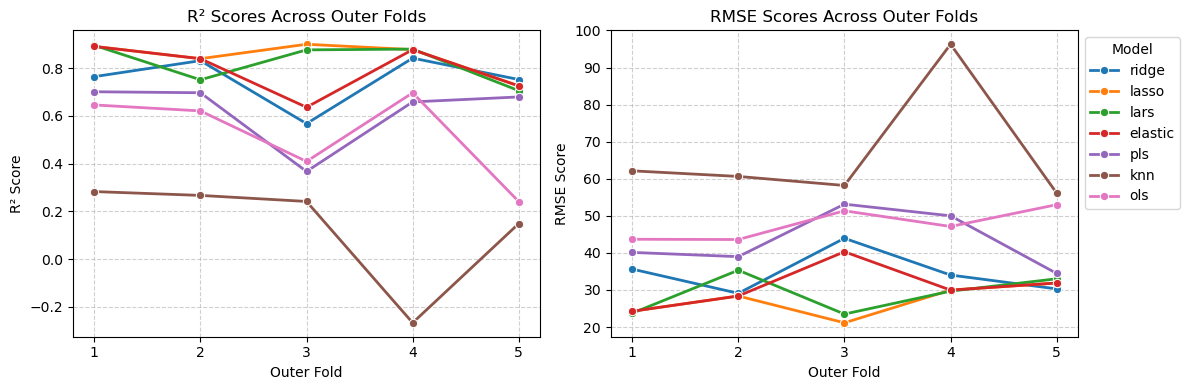

In [22]:
# Convert model_r2_dict into a DataFrame
r2_df = pd.DataFrame(model_r2_dict)
r2_df.index.name = "Fold"
r2_df = r2_df.reset_index()
r2_df["Fold"] += 1  # Start fold numbering from 1
r2_df = r2_df.melt(id_vars=["Fold"], var_name="Model", value_name="R²")

# Convert model_rmse_dict into a DataFrame
rmse_df = pd.DataFrame(model_rmse_dict)
rmse_df.index.name = "Fold"
rmse_df = rmse_df.reset_index()
rmse_df["Fold"] += 1  # Start fold numbering from 1
rmse_df = rmse_df.melt(id_vars=["Fold"], var_name="Model", value_name="RMSE")

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Define a custom color palette (optional)
palette = sns.color_palette("tab10")

# R² plot (Remove legend)
sns.lineplot(data=r2_df, x="Fold", y="R²", hue="Model", marker="o", linewidth=2, palette=palette, ax=axes[0])
axes[0].set_title("R² Scores Across Outer Folds")
axes[0].set_ylabel("R² Score")
axes[0].set_xlabel("Outer Fold")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].get_legend().remove()  # Remove legend from the first plot
axes[0].set_xticks(range(r2_df["Fold"].min(), r2_df["Fold"].max() + 1, 1))  # Ensure x-axis increments by 1

# RMSE plot (Keep legend)
sns.lineplot(data=rmse_df, x="Fold", y="RMSE", hue="Model", marker="o", linewidth=2, palette=palette, ax=axes[1])
axes[1].set_title("RMSE Scores Across Outer Folds")
axes[1].set_ylabel("RMSE Score")
axes[1].set_xlabel("Outer Fold")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend(title="Model", bbox_to_anchor=(1, 1), loc="upper left")  # Keep legend in second plot
axes[1].set_xticks(range(rmse_df["Fold"].min(), rmse_df["Fold"].max() + 1, 1))  # Ensure x-axis increments by 1

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

#### Dependancy on random_state?

In [23]:
# List of random states for the outer loop
random_states = [6, 42, 100, 202, 123]

# Lists to store the results for each random state
outer_results_all_states = []

# Loop over the different random states for the outer fold
for rand_state in random_states:
    print(f'\nRunning cross-validation with random_state={rand_state}')
    
    # Cross-validation procedure (outer loop) with current random state
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=rand_state)

    # Lists to store the results for each fold
    outer_results = []
    model_rmse_dict = {model_name: [] for model_name in models_dict.keys()}
    model_r2_dict = {model_name: [] for model_name in models_dict.keys()}
    model_best_params_dict = {model_name: [] for model_name in models_dict.keys()}

    # Loop over the outer cross-validation splits
    for fold_num, (train_ix, test_ix) in enumerate(cv_outer.split(X), 1):
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

        cv_inner = KFold(n_splits=5, shuffle=True, random_state=6)

        best_rmse = float('inf')
        best_r2 = float('-inf')
        best_model_name = None
        best_params = None

        for model_name, (model, param_grid) in models_dict.items():
            if model_name != "ols":  # Skip GridSearch for OLS (no hyperparameters)
                search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=cv_inner, refit=True)
                search.fit(X_train, y_train)
                best_model = search.best_estimator_
                best_params = search.best_params_
            else:
                best_model = model.fit(X_train, y_train)
                best_params = None  # No hyperparameters for OLS

            # Predict and evaluate
            yhat = best_model.predict(X_test)
            rmse = root_mean_squared_error(y_test, yhat)
            r2 = r2_score(y_test, yhat)

            model_rmse_dict[model_name].append(rmse)
            model_r2_dict[model_name].append(r2)
            model_best_params_dict[model_name].append(best_params)

            if rmse < best_rmse:
                best_rmse = rmse
                best_r2 = r2
                best_model_name = model_name
                best_params = best_params if model_name != "ols" else None  # Ensure correct param tracking

        # Store the best model for each fold
        outer_results.append((fold_num, best_model_name, best_rmse, best_r2, best_params))
        print(f'Fold {fold_num}: Best Model: {best_model_name}, RMSE={best_rmse:.3f}, R²={best_r2:.3f}')
        print(f'Best Hyperparameters: {model_best_params_dict[best_model_name][fold_num-1]}')

    # Store results for this random state
    outer_results_all_states.append({
        'random_state': rand_state,
        'outer_results': outer_results,
        'model_rmse_dict': model_rmse_dict,
        'model_r2_dict': model_r2_dict,
        'model_best_params_dict': model_best_params_dict
    })

    # Summary statistics for this random state
    print(f'\nSummary for random_state={rand_state}:')
    print('Overall RMSE and R² for each model:')
    for model_name in models_dict.keys():
        overall_rmse = np.mean(model_rmse_dict[model_name])
        overall_r2 = np.mean(model_r2_dict[model_name])
        print(f'{model_name}: Overall RMSE={overall_rmse:.3f}, Overall R²={overall_r2:.3f}')


Running cross-validation with random_state=6
Fold 1: Best Model: lars, RMSE=23.731, R²=0.895
Best Hyperparameters: {'n_nonzero_coefs': 21}
Fold 2: Best Model: lasso, RMSE=28.374, R²=0.839
Best Hyperparameters: {'alpha': 1}
Fold 3: Best Model: lasso, RMSE=21.146, R²=0.900
Best Hyperparameters: {'alpha': 0.9}
Fold 4: Best Model: lars, RMSE=29.684, R²=0.880
Best Hyperparameters: {'n_nonzero_coefs': 20}
Fold 5: Best Model: ridge, RMSE=30.289, R²=0.752
Best Hyperparameters: {'alpha': 3}

Summary for random_state=6:
Overall RMSE and R² for each model:
ridge: Overall RMSE=34.599, Overall R²=0.751
lasso: Overall RMSE=27.124, Overall R²=0.847
lars: Overall RMSE=29.051, Overall R²=0.822
elastic: Overall RMSE=30.956, Overall R²=0.794
pls: Overall RMSE=43.346, Overall R²=0.620
knn: Overall RMSE=66.673, Overall R²=0.135
ols: Overall RMSE=47.757, Overall R²=0.523

Running cross-validation with random_state=42
Fold 1: Best Model: lasso, RMSE=26.668, R²=0.891
Best Hyperparameters: {'alpha': 0.9}
Fold

# Lasso 1-std-error-rule

In [40]:
# Define range of alphas
alphas = np.linspace(0, 5, 50)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=6)

# Store performance across folds
rmse_matrix = []
r2_matrix = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    fold_rmse = []
    fold_r2 = []
    for alpha in alphas:
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        fold_rmse.append(rmse)
        fold_r2.append(r2)

    rmse_matrix.append(fold_rmse)
    r2_matrix.append(fold_r2)

# Convert to array for easier manipulation
rmse_matrix = np.array(rmse_matrix)  # Shape: (n_outer_folds, n_alphas)
r2_matrix = np.array(r2_matrix)

# Compute mean and std RMSE for each alpha
mean_rmse_per_alpha = rmse_matrix.mean(axis=0)
std_rmse_per_alpha = rmse_matrix.std(axis=0)

mean_r2_per_alpha = r2_matrix.mean(axis=0)
std_r2_per_alpha = r2_matrix.std(axis=0)

# Best alpha = lowest mean RMSE
best_alpha_idx = np.argmin(mean_rmse_per_alpha)
best_alpha = alphas[best_alpha_idx]
best_rmse = mean_rmse_per_alpha[best_alpha_idx]
best_rmse_std = std_rmse_per_alpha[best_alpha_idx]

best_r2 = mean_r2_per_alpha[best_alpha_idx]
best_r2_std = std_r2_per_alpha[best_alpha_idx]

# 1-std rule: pick most regularized alpha within 1 std of best
candidate_indices = np.where(mean_rmse_per_alpha <= best_rmse + best_rmse_std)[0]
one_std_idx = candidate_indices[-1]
one_std_alpha = alphas[one_std_idx]
rmse_one_std = mean_rmse_per_alpha[one_std_idx]

print(f"Best alpha: {best_alpha}")
print(f"Best RMSE: {best_rmse}")
print(f"Best RMSE std: {best_rmse_std}")

print(f"1-std-rule alpha: {one_std_alpha}")
print(f"RMSE for 1-std-rule alpha: {rmse_one_std}")

Best alpha: 0.9183673469387755
Best RMSE: 25.357470613110273
Best RMSE std: 4.200534668379505
1-std-rule alpha: 4.387755102040816
RMSE for 1-std-rule alpha: 29.45562341152646


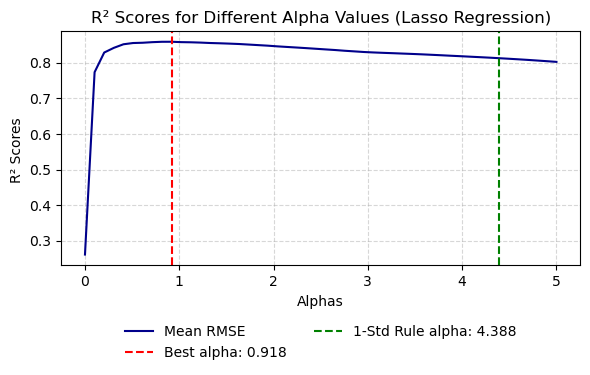

In [41]:
# Plot RMSE vs Alpha
plt.figure(figsize=(6, 4))
plt.plot(alphas, mean_r2_per_alpha, label='Mean RMSE', color='darkblue')
#plt.fill_between(alphas,
#                 mean_r2_per_alpha - std_r2_per_alpha,
#                 mean_r2_per_alpha + std_r2_per_alpha,
#                 alpha=0.2, color='darkblue', label='±1 std dev')

# Mark best alpha (lowest mean RMSE)
plt.axvline(best_alpha, linestyle='--', color='red',
            label=f'Best alpha: {round(best_alpha, 3)}')

# Mark alpha from 1-standard-error rule
plt.axvline(one_std_alpha, linestyle='--', color='green',
            label=f'1-Std Rule alpha: {round(one_std_alpha, 3)}')

# Labels and formatting
plt.xlabel('Alphas')
plt.ylabel('R² Scores ')
plt.title('R² Scores for Different Alpha Values (Lasso Regression)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [42]:
lassoFinal = Lasso(alpha=one_std_alpha)
lassoFinal.fit(Xall, yall)
joblib.dump(lassoFinal, "LassoTrained_model.pkl")

['LassoTrained_model.pkl']

# Darafting

In [ ]:
# Define range of alphas for Lasso
alphas = np.linspace(0, 5, 50)

# Outer cross-validation (e.g., 5-fold)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=6)

# Store results for both Best and One Standard Error Rule models
test_r2_lasso_best = []
test_RMSE_lasso_best = []
test_MSE_lasso_best = []

test_r2_lasso_1std = []
test_RMSE_lasso_1std = []
test_MSE_lasso_1std = []

# Store alpha scores and means/stds across folds
all_alpha_scores = []
alpha_means = []
alpha_stds = []

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Data preprocessing
    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    # Inner cross-validation for hyperparameter tuning
    best_score = -np.inf
    best_alpha_lasso = None
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=6)

    fold_alpha_scores = []
    inner_alpha_means = []
    inner_alpha_stds = []

    for alpha in alphas:
        inner_r2 = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
            X_inner_train, X_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

            model = Lasso(alpha=alpha)
            model.fit(X_inner_train, y_inner_train)
            inner_r2.append(r2_score(y_val, model.predict(X_val)))

        # Calculate mean and std for each alpha across inner folds
        mean_inner_r2 = np.mean(inner_r2)
        std_inner_r2 = np.std(inner_r2)

        inner_alpha_means.append(mean_inner_r2)
        inner_alpha_stds.append(std_inner_r2)
        fold_alpha_scores.append(mean_inner_r2)

        if mean_inner_r2 > best_score:
            best_score = mean_inner_r2
            best_alpha_lasso = alpha

    all_alpha_scores.append(fold_alpha_scores)
    alpha_means.append(inner_alpha_means)
    alpha_stds.append(inner_alpha_stds)

    # Determine best alpha's mean and std deviation across all folds
    mean_r2_all_folds = np.mean(alpha_means, axis=0)
    std_r2_all_folds = np.mean(alpha_stds, axis=0)

    best_mean_r2 = np.max(mean_r2_all_folds)
    best_std_r2 = std_r2_all_folds[np.argmax(mean_r2_all_folds)]

    # Apply One Standard Error Rule
    acceptable_models = [i for i, mean_r2 in enumerate(mean_r2_all_folds) if best_mean_r2 - best_std_r2 <= mean_r2]
    selected_model_idx = acceptable_models[-1] if len(acceptable_models) > 0 else np.argmax(mean_r2_all_folds)
    one_std_alpha_lasso = alphas[selected_model_idx]

    # Train and evaluate both the best model and the One Standard Error Rule model
    final_model_best = Lasso(alpha=best_alpha_lasso)
    final_model_best.fit(X_train, y_train)

    final_model_1std = Lasso(alpha=one_std_alpha_lasso)
    final_model_1std.fit(X_train, y_train)

    # Predictions for best model
    y_pred_best = final_model_best.predict(X_test)
    test_r2_lasso_best.append(r2_score(y_test, y_pred_best))
    test_RMSE_lasso_best.append(root_mean_squared_error(y_test, y_pred_best))
    test_MSE_lasso_best.append(mean_squared_error(y_test, y_pred_best))

    # Predictions for One Standard Error Rule model
    y_pred_1std = final_model_1std.predict(X_test)
    test_r2_lasso_1std.append(r2_score(y_test, y_pred_1std))
    test_RMSE_lasso_1std.append(root_mean_squared_error(y_test, y_pred_1std))
    test_MSE_lasso_1std.append(mean_squared_error(y_test, y_pred_1std))

# Convert lists of means and stds to NumPy arrays for easier indexing
alpha_means = np.array(alpha_means)  # Shape will be (n_folds, n_alphas)
alpha_stds = np.array(alpha_stds)    # Shape will be (n_folds, n_alphas)

# Output results for Lasso Best model
print(f"Best alpha: {best_alpha_lasso}")
print("Final estimated R² score (mean over outer folds) - Lasso Best model:", np.mean(test_r2_lasso_best))
print("Final estimated MSE score (mean over outer folds) - Lasso Best model:", np.mean(test_MSE_lasso_best))
print("Final estimated RMSE score (mean over outer folds) - Lasso Best model:", np.mean(test_RMSE_lasso_best))

# Output results for Lasso model selected by One Standard Error Rule
print("\nOne Standard Error Rule Model - Lasso:")
print(f"Selected alpha: {one_std_alpha_lasso}")
print("Final estimated R² score (mean over outer folds) - Lasso 1std model:", np.mean(test_r2_lasso_1std))
print("Final estimated MSE score (mean over outer folds) - Lasso 1std model:", np.mean(test_MSE_lasso_1std))
print("Final estimated RMSE score (mean over outer folds) - Lasso 1std model:", np.mean(test_RMSE_lasso_1std))

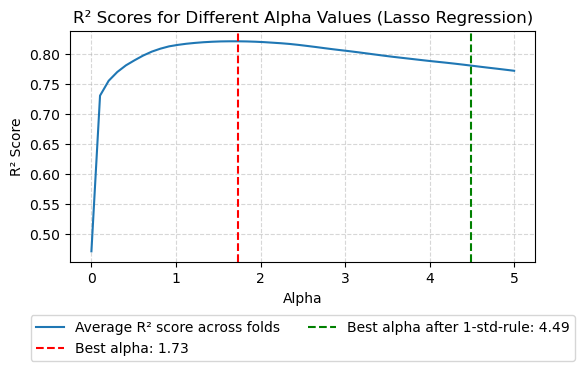

In [34]:
plt.figure(figsize=(6, 3))
mean_alpha_scores = np.mean(all_alpha_scores, axis=0)  # Average R² score for each alpha across all folds
plt.plot(alphas, mean_alpha_scores, label='Average R² score across folds')

# Round values to 3 decimal places
best_alpha_rounded = round(best_alpha_lasso, 3)
selected_alpha_rounded = round(alphas[selected_model_idx], 3)

plt.axvline(best_alpha_lasso, color='r', linestyle='--', label=f"Best alpha: {round(best_alpha_lasso,2)}")
plt.axvline(alphas[selected_model_idx], color='g', linestyle='--', label=f"Best alpha after 1-std-rule: {round(one_std_alpha_lasso, 2)}")

plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Scores for Different Alpha Values (Lasso Regression)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Move legend below the graph
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()